In [3]:
import os
import copy

import pcl
import pyntcloud

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [4]:
seq_list = {
  0 : "unlabeled",
  1 : "outlier",
  10: "car",
  11: "bicycle",
  13: "bus",
  15: "motorcycle",
  16: "on-rails",
  18: "truck",
  20: "other-vehicle",
  30: "person",
  31: "bicyclist",
  32: "motorcyclist",
  40: "road",
  44: "parking",
  48: "sidewalk",
  49: "other-ground",
  50: "building",
  51: "fence",
  52: "other-structure",
  60: "lane-marking",
  70: "vegetation",
  71: "trunk",
  72: "terrain",
  80: "pole",
  81: "traffic-sign",
  99: "other-object",
  252: "moving-car",
  253: "moving-bicyclist",
  254: "moving-person",
  255: "moving-motorcyclist",
  256: "moving-on-rails",
  257: "moving-bus",
  258: "moving-truck",
  259: "moving-other-vehicle"
}

In [5]:
obstacle_lst = {
  10: "car",
  11: "bicycle",
  13: "bus",
  15: "motorcycle",
  16: "on-rails",
  18: "truck",
  20: "other-vehicle",
  30: "person",
  31: "bicyclist",
  32: "motorcyclist",
  252: "moving-car",
  253: "moving-bicyclist",
  254: "moving-person",
  255: "moving-motorcyclist",
  256: "moving-on-rails",
  257: "moving-bus",
  258: "moving-truck",
  259: "moving-other-vehicle"
}

In [286]:
num ='066'
scan = np.fromfile('dataset/sequences/00/velodyne/000' + num + '.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))

label = np.fromfile('dataset/sequences/00/labels/000' + num + '.label', dtype=np.uint32)
label = label.reshape((-1))

In [287]:
label = [seg & 0xFFFF for seg in label]
unq = list(set(label))
for seg in unq:
    if seg in list(seq_list.keys()):
        print(seg,seq_list[seg])

0 unlabeled
1 outlier
99 other-object
70 vegetation
71 trunk
72 terrain
40 road
10 car
11 bicycle
44 parking
80 pole
81 traffic-sign
50 building
51 fence
48 sidewalk
20 other-vehicle


In [288]:
scan = scan[:,:3]
scan

array([[70.625824 ,  6.268895 ,  2.6012962],
       [70.8584   ,  6.513852 ,  2.6100776],
       [70.49497  ,  6.703819 ,  2.5979092],
       ...,
       [ 3.7858496, -1.4187256, -1.7453413],
       [ 3.7884095, -1.4067276, -1.7443551],
       [ 3.7909355, -1.3937299, -1.7433698]], dtype=float32)

In [289]:
pcloud = pd.DataFrame(scan, columns=['x', 'y', 'z'])

In [290]:
def roi_filter(pcloud, verbose=True, **params):
    if verbose:
        print('Input pcloud size: {}'.format(len(pcloud)))
    pcloud['camera'] = ((pcloud['x'] > params['min_x']) & (pcloud['x'] < params['max_x']) &
                       (pcloud['y'] >  params['min_y']) & (pcloud['y'] < params['max_y']) &
                       (pcloud['z'] >  params['min_z']) & (pcloud['z'] <  params['max_z']))
    pcloud = pcloud[pcloud['camera'] == True]
    if verbose:
        print('Output ROI pcloud size: {}'.format(len(pcloud)))
    return pcloud

In [291]:
pcloud = roi_filter(pcloud, min_x=-6, max_x=50, 
                   min_y=-20, max_y=25, 
                   min_z=-2, max_z=2)

Input pcloud size: 121199
Output ROI pcloud size: 92395


In [292]:
test_cloud = pyntcloud.PyntCloud(pd.DataFrame(scan,columns=['x','y','z']))

test_cloud.points['seg_id'] = pd.Series(label)

seg_count = test_cloud.points.groupby(test_cloud.points['seg_id']).count()
seg_count['Proportion'] = seg_count['x'] / seg_count['x'].sum() * 100
np.around(seg_count,2)

,x,y,z,Proportion
seg_id,,,,
0,1023,1023,1023,0.84
1,72,72,72,0.06
10,16931,16931,16931,13.97
11,10,10,10,0.01
20,1081,1081,1081,0.89
40,22874,22874,22874,18.87
44,15128,15128,15128,12.48
48,8006,8006,8006,6.61
50,40970,40970,40970,33.80


In [293]:
# test_cloud.plot(use_as_color='seg_id', cmap="cool")
pcloud = pyntcloud.PyntCloud(pcloud)
pcloud.plot(use_as_color='camera', cmap="cool")

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(3.891500473022461, 21.006840467453003, 1.820…

In [294]:
is_parking = ~test_cloud.points['seg_id'].isin(list(obstacle_lst.keys()))
test_cloud.points['is_parking'] = pd.Series(is_parking)

In [295]:
test_cloud.plot(use_as_color='is_parking', cmap="RdYlGn", output_name="is_parking")

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.14305366575717926, 59.59479224681854, 3.6…

In [88]:
is_parking = test_cloud.points['is_parking'] != 1
test_cloud.apply_filter(is_parking)

In [89]:
test_cloud.plot()

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.6519368290901184, 11.051446095108986, -0.…

In [90]:
n_voxels = 45
voxelgrid_id = test_cloud.add_structure("voxelgrid", n_x=n_voxels, n_y=n_voxels, n_z=10)

In [91]:
%time cluster_id = test_cloud.add_scalar_field("euclidean_clusters",voxelgrid_id=voxelgrid_id)

CPU times: user 1.6 s, sys: 0 ns, total: 1.6 s
Wall time: 1.61 s


In [92]:
test_cloud.points

,x,y,z,seg_id,is_parking,"clusters(V([45, 45, 10],[None, None, None],True))"
0,49.832928,0.346920,0.364062,255,False,11.0
1,49.833443,0.503884,0.364089,255,False,11.0
2,23.588537,-4.080956,0.281311,10,False,9.0
3,23.532047,-3.994977,0.281330,10,False,9.0
4,23.527802,-3.955987,0.281339,10,False,9.0
...,...,...,...,...,...,...
16047,-0.582559,-3.069018,-1.368003,10,False,4.0
16048,-0.577004,-3.082017,-1.373020,10,False,4.0
16049,-0.586246,-3.134008,-1.398051,10,False,4.0
16050,-0.589702,-3.182001,-1.420086,10,False,4.0


In [93]:
test_cloud.plot(use_as_color=cluster_id, cmap="cool")

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.6519368290901184, 11.051446095108986, -0.…

In [18]:
test_cloud.points[test_cloud.points.columns[-1]].nunique()

9

In [14]:
def get_bounding_boxes(clusters):
    box_coord_list = []
    for i in range(len(clusters)):
        x_min, x_max, y_min, y_max, z_min, z_max =  list(clusters.iloc[i])
        box = np.zeros([8, 3])
        box[0, :] = [x_min, y_min, z_min]
        box[1, :] = [x_max, y_min, z_min]
        box[2, :] = [x_max, y_max, z_min]
        box[3, :] = [x_min, y_max, z_min]
        box[4, :] = [x_min, y_min, z_max]
        box[5, :] = [x_max, y_min, z_max]
        box[6, :] = [x_max, y_max, z_max]
        box[7, :] = [x_min, y_max, z_max]
        box = np.transpose(box)
        box_coord_list.append(box)
    return box_coord_list

In [142]:
def get_optimal_bboxes(clusters, cluster_data):
    box_coord_list = []
    cov_matrix = np.cov(cluster_data[['x', 'y', 'z']].T, bias=False)
    eig = np.linalg.eig(cov_matrix)
    clusters = []
    for cl_id in cluster_data.cluster_id.unique():
        cluster = cluster_data[cluster_data.cluster_id == cl_id]
        cluster = np.dot(cluster[['x', 'y', 'z']], eig[1])
        cluster = pd.DataFrame(cluster, columns = ['x', 'y', 'z'])
        cluster = cluster.agg({ 'x':['min','max'],
                                'y':['min','max'],
                                'z':['min','max']
                                  })
        clusters.append(cluster.T)
#     return clusters
    for i in range(len(clusters)):
        x_min, x_max =  list(clusters[i].values[0])
        y_min, y_max =  list(clusters[i].values[1])
        z_min, z_max =  list(clusters[i].values[2])
        box = np.zeros([8, 3])
        box[0, :] = [x_min, y_min, z_min]
        box[1, :] = [x_max, y_min, z_min]
        box[2, :] = [x_max, y_max, z_min]
        box[3, :] = [x_min, y_max, z_min]
        box[4, :] = [x_min, y_min, z_max]
        box[5, :] = [x_max, y_min, z_max]
        box[6, :] = [x_max, y_max, z_max]
        box[7, :] = [x_min, y_max, z_max]
       
        box = np.transpose(box)
        box_coord_list.append(box)
    return box_coord_list

In [ ]:
def get_optim_diam(cloud_data):
    
def get_optim_diam_bboxes(clusters, cluster_data):
    
    cov_matrix = np.cov(cluster_data[['x', 'y', 'z']].T, bias=False)
    eig = np.linalg.eig(cov_matrix)
    clusters = []
    for cl_id in cluster_data.cluster_id.unique():
        cluster = cluster_data[cluster_data.cluster_id == cl_id]
        cluster = np.dot(cluster[['x', 'y', 'z']], eig[1])
        cluster = pd.DataFrame(cluster, columns = ['x', 'y', 'z'])
        cluster = cluster.agg({ 'x':['min','max'],
                                'y':['min','max'],
                                'z':['min','max']
                                  })
        clusters.append(cluster.T)
#     return clusters

    box_coord_list = []
    for i in range(len(clusters)):
        x_min, x_max =  list(clusters[i].values[0])
        y_min, y_max =  list(clusters[i].values[1])
        z_min, z_max =  list(clusters[i].values[2])
        box = np.zeros([8, 3])
        box[0, :] = [x_min, y_min, z_min]
        box[1, :] = [x_max, y_min, z_min]
        box[2, :] = [x_max, y_max, z_min]
        box[3, :] = [x_min, y_max, z_min]
        box[4, :] = [x_min, y_min, z_max]
        box[5, :] = [x_max, y_min, z_max]
        box[6, :] = [x_max, y_max, z_max]
        box[7, :] = [x_min, y_max, z_max]
       
        box = np.transpose(box)
        box_coord_list.append(box)
    return box_coord_list

In [143]:
box_coord_list = get_optimal_bboxes(clusters, cluster_data)
print(len(box_coord_list))

9


In [144]:
box_coord_list[0]

array([[ 48.70651688,  49.7368977 ,  49.7368977 ,  48.70651688,
         48.70651688,  49.7368977 ,  49.7368977 ,  48.70651688],
       [-11.20491019, -11.20491019,  -3.76629778,  -3.76629778,
        -11.20491019, -11.20491019,  -3.76629778,  -3.76629778],
       [ -1.25901966,  -1.25901966,  -1.25901966,  -1.25901966,
         -0.08540759,  -0.08540759,  -0.08540759,  -0.08540759]])

In [52]:
%time box_coord_list= get_optimal_bboxes(clusters, cluster_data)

           x          y         z
x  85.525667  -4.817763  1.037990
y  -4.817763  17.391380 -0.858261
z   1.037990  -0.858261  0.202956
(array([85.87865713, 17.08870068,  0.15264467]), array([[ 0.9974421 , -0.07084663, -0.00948757],
       [-0.07032571, -0.99641255,  0.0470778 ],
       [ 0.01278884,  0.04629016,  0.99884617]]))
CPU times: user 14 ms, sys: 0 ns, total: 14 ms
Wall time: 16.6 ms


In [6]:
def get_selected_segs(scan, label, obstacle_lst):
    
    # get segment id
    label = [seg & 0xFFFF for seg in label]
    unq = list(set(label))
     
    pcloud = pyntcloud.PyntCloud(pd.DataFrame(scan,columns=['x','y','z']))
    pcloud.points['seg_id'] = pd.Series(label)
    
    is_obstacle = ~pcloud.points['seg_id'].isin(list(obstacle_lst.keys()))
    pcloud.points['is_obstacle'] = pd.Series(is_obstacle)
    
    is_obstacle = pcloud.points['is_obstacle'] != 1
    pcloud.apply_filter(is_obstacle)
    
    return pcloud
    

In [7]:
from datetime import datetime
import time


def pipeline(scan, label, obstacle_lst, n_voxels=40, verbose=False):
    
    # get segment id
    start_time = datetime.now()
    label = [seg & 0xFFFF for seg in label]
    unq = list(set(label))
    print('get segment id: ',datetime.now() - start_time)
    
    # get segments
    start_time = datetime.now()
    if verbose:
        print('get segments')
    pcloud = pyntcloud.PyntCloud(pd.DataFrame(scan,columns=['x','y','z']))
    pcloud.points['seg_id'] = pd.Series(label)
    print('get segments: ',datetime.now() - start_time)
    
    # filter chosen segments
    start_time = datetime.now()
    if verbose:
        print('filter needed segments')
    is_obstacle = ~pcloud.points['seg_id'].isin(list(obstacle_lst.keys()))
    pcloud.points['is_obstacle'] = pd.Series(is_obstacle)
    
    
    #TODO: pandas filter 
    
    is_obstacle = pcloud.points['is_obstacle'] != 1
    pcloud.apply_filter(is_obstacle)
    print('filtering: ',datetime.now() - start_time)
    
    # get voxel grid
    start_time = datetime.now()
    if verbose:
        print('get voxel grid')
    voxelgrid_id = pcloud.add_structure("voxelgrid", n_x=n_voxels, n_y=n_voxels, n_z=15)
    print('voxel grid: ',datetime.now() - start_time)
    
    # get cluster
    start_time = datetime.now()
    if verbose:
        print('get cluster')
    cluster_id = pcloud.add_scalar_field("euclidean_clusters", voxelgrid_id=voxelgrid_id)
    print('clustering: ',datetime.now() - start_time)
    
    # get cluster min max
    start_time = datetime.now()
    if verbose:
        print('get cluster min max')
    clusters = pcloud.points.groupby([cluster_id]).agg({ 'x':['min','max'],
                                                         'y':['min','max'],
                                                         'z':['min','max']
                                                       })
    print('min-max cluster points: ',datetime.now() - start_time)
    
    return clusters

In [41]:
def pipeline_optimized(scan, label, obstacle_lst, verbose=False, **params):
    
    # get segment id
    start_time = datetime.now()
    pcloud = pd.DataFrame(np.concatenate((scan,label.reshape(len(label), 1)), axis=1), 
                          columns=['x', 'y', 'z', 'seg_id'])
    pcloud.seg_id = pcloud.seg_id.astype('uint32')
    pcloud.seg_id = pcloud.seg_id.apply(lambda x: x & 0xFFFF)
    print('get segments: ',datetime.now() - start_time)
    
    # filter chosen segments
    start_time = datetime.now()
    if verbose:
        print('filter needed segments')
    pcloud = pcloud[pcloud['seg_id'].isin(list(obstacle_lst.keys()))]
    pcloud = pyntcloud.PyntCloud(pcloud)
    print('filtering: ',datetime.now() - start_time)
    
    # get voxel grid
    start_time = datetime.now()
    if verbose:
        print('get voxel grid')
    voxelgrid_id = pcloud.add_structure("voxelgrid", n_x=params['x_voxels'], 
                                                     n_y=params['y_voxels'],
                                                     n_z=params['z_voxels'])
    print('voxel grid: ', datetime.now() - start_time)
    
    # get cluster
    start_time = datetime.now()
    if verbose:
        print('get cluster')
    cluster_id = pcloud.add_scalar_field("euclidean_clusters", voxelgrid_id=voxelgrid_id)
    print('clustering: ', datetime.now() - start_time)
    
    # get cluster min max
    start_time = datetime.now()
    if verbose:
        print('get cluster min max')
    clusters = pcloud.points.groupby([cluster_id]).agg({ 'x':['min','max'],
                                                         'y':['min','max'],
                                                         'z':['min','max']
                                                       })
    print('min-max cluster points: ',datetime.now() - start_time)
    
    return clusters, pcloud.points[['x', 'y', 'z', cluster_id]].rename(columns = 
                                                                       {cluster_id: 'cluster_id'})

In [9]:
# !pip install sklearn

In [10]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN
# clustering = AgglomerativeClustering().fit(X)

def pipeline_separate_clustering(scan, label, obstacle_lst, n_voxels=40,
                                 tol_distance=1, verbose=False):
    
    # get segment id
    start_time = datetime.now()
    pcloud = pd.DataFrame(np.concatenate((scan,label.reshape(len(label), 1)), axis=1), 
                          columns=['x', 'y', 'z', 'seg_id'])
    pcloud.seg_id = pcloud.seg_id.astype('uint32')
    pcloud.seg_id = pcloud.seg_id.apply(lambda x: x & 0xFFFF)
    print('get segments: ',datetime.now() - start_time)
    
    # filter chosen segments
    start_time = datetime.now()
    if verbose:
        print('filter needed segments')
    pcloud = pcloud[pcloud['seg_id'].isin(list(obstacle_lst.keys()))]
    print('filtering: ',datetime.now() - start_time)
    
   
    start_time = datetime.now()
    unq_seg = list(pcloud.seg_id.unique())
    print('get unique: ',datetime.now() - start_time)    
    
    clusters = pd.DataFrame.from_dict({('x', 'min'):[],('x', 'max'):[],
                                       ('y', 'min'):[],('y', 'max'):[],
                                       ('z', 'min'):[],('z', 'max'):[]})
    for seg in unq_seg:
        start_time = datetime.now()
        cloud = pcloud[pcloud.seg_id == seg]
        clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=tol_distance, 
                                             compute_full_tree=False)
        if len(cloud) < 200 or len(cloud) > 30000:
            continue
        clustering = DBSCAN(eps=tol_distance)
#         clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=tol_distance)
        clustering.fit(cloud[['x', 'y', 'z']].values)
        cloud['cluster_id'] = clustering.labels_
        cluster = cloud.groupby(['cluster_id']).agg({ 'x':['min', 'max'],
                                                      'y':['min', 'max'],
                                                      'z':['min', 'max']
                                                    })
        cluster = cluster.reset_index(drop=True)
        clusters = clusters.append(cluster)
        print('Seg: {} cloud size: {}  clustering time: {} has {} clusters'.format(seg, len(cloud),
                                                                  datetime.now() - start_time,
                                                                  len(cluster)))
    return clusters

## Pipeline implementation

In [11]:
%time 
scan = np.fromfile('dataset/sequences/00/velodyne/000050.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))[:,:3]

label = np.fromfile('dataset/sequences/00/labels/000050.label', dtype=np.uint32)
label = label.reshape((-1))

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 13.6 µs


In [12]:
%time clusters = pipeline(scan, label, obstacle_lst)

get segment id:  0:00:01.011319
get segments:  0:00:00.107354
filtering:  0:00:00.007155
voxel grid:  0:00:00.002160
clustering:  0:00:00.742959
min-max cluster points:  0:00:00.029556
CPU times: user 1.93 s, sys: 0 ns, total: 1.93 s
Wall time: 1.95 s


In [28]:
%time box_coord_list = get_bounding_boxes(clusters)
print(len(box_coord_list))

CPU times: user 6.16 ms, sys: 0 ns, total: 6.16 ms
Wall time: 9.73 ms
9


In [99]:
%%time
clusters, cluster_data = pipeline_optimized(scan, label, obstacle_lst, 
                                                       x_voxels=30,
                                                       y_voxels=20,
                                                       z_voxels=5)

get segments:  0:00:00.255565
filtering:  0:00:00.010940
voxel grid:  0:00:00.002687
clustering:  0:00:00.454864
min-max cluster points:  0:00:00.029392
CPU times: user 745 ms, sys: 8.74 ms, total: 753 ms
Wall time: 761 ms


In [43]:
cluster_data

,x,y,z,cluster_id
10047,49.832928,0.346920,0.364062,1.0
10048,49.833443,0.503884,0.364089,1.0
12011,23.588537,-4.080956,0.281311,3.0
12012,23.532047,-3.994977,0.281330,3.0
12013,23.527802,-3.955987,0.281339,3.0
...,...,...,...,...
118220,-0.582559,-3.069018,-1.368003,6.0
118221,-0.577004,-3.082017,-1.373020,6.0
118222,-0.586246,-3.134008,-1.398051,6.0
118223,-0.589702,-3.182001,-1.420086,6.0


In [27]:
%time box_coord_list = get_bounding_boxes(clusters)
print(len(box_coord_list))

CPU times: user 3.22 ms, sys: 966 µs, total: 4.18 ms
Wall time: 6.43 ms
9


In [20]:
%time clusters = pipeline_separate_clustering(scan, label, obstacle_lst, tol_distance=2)

In [109]:
box_coord_list = get_bounding_boxes(clusters)
print(len(box_coord_list))

18


In [116]:
box_coord_list = get_optimal_bboxes(clusters, cluster_data)
print(len(box_coord_list))

ValueError: not enough values to unpack (expected 6, got 2)

In [45]:
# box_coord_list

In [21]:
# axes_limits = [
#     [int(x_min*1.2), int(x_max*1.2)], # X axis range
#     [int(y_min*1.2), int(y_max*1.2)], # Y axis range
#     [-5, 5]   # Z axis range
# ]
axes_str = ['X', 'Y', 'Z']

def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='red'):
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color)
        
def draw_point_cloud(cloud, ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
        
        no_points = np.shape(cloud)[0]
        point_size = 10 ** (3 - int(np.log10(no_points))) # Adjust the point size based on the point cloud size
        if np.shape(cloud)[1] == 4:                    # If point cloud is XYZI format (e.g., I stands for intensity)
            ax.scatter(*np.transpose(cloud[:, axes]), s = point_size, c=cloud[:, 3], cmap='gray')
        elif np.shape(cloud)[1] == 3:                  # If point cloud is XYZ format 
            ax.scatter(*np.transpose(cloud[:, axes]), s = point_size, c='b', alpha = 0.7)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
#         if len(axes) > 2: # 3-D plot
#             ax.set_xlim3d(axes_limits[axes[0]])
#             ax.set_ylim3d(axes_limits[axes[1]])
#             ax.set_zlim3d(axes_limits[axes[2]])
#             ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
#         else: # 2-D plot
#             ax.set_xlim(*axes_limits[axes[0]])
#             ax.set_ylim(*axes_limits[axes[1]])
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
        ax.set_title(title)

<IPython.core.display.Javascript object>


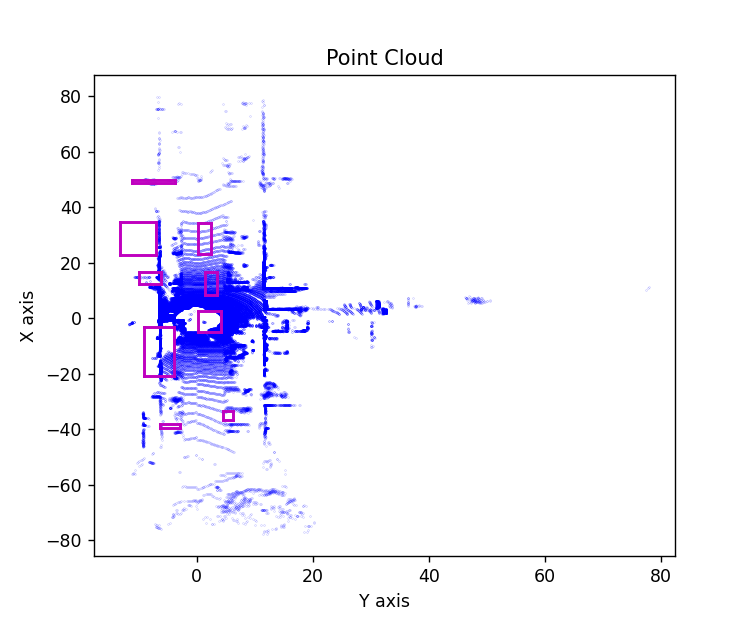

In [145]:
f = plt.figure(figsize=(6, 5))
axes = [1,0]
# ax = f.add_subplot(111, projection='3d') 
ax = f.add_subplot(111) 
draw_point_cloud(scan, ax, 'Point Cloud',axes=axes)
for box in box_coord_list:
     draw_box(ax, box, axes=axes, color='m')

In [104]:
%time cloud = get_selected_segs(scan, label, obstacle_lst)

CPU times: user 1.79 s, sys: 2.59 ms, total: 1.8 s
Wall time: 1.81 s


In [105]:
cloud

PyntCloud
16052 points with 2 scalar fields
0 faces in mesh
0 kdtrees
0 voxelgrids
Centroid: -0.6519368290901184, 0.1141292005777359, -0.8980430960655212
Other attributes:

In [106]:
spoints = cloud.points[['x','y','z']]

<IPython.core.display.Javascript object>


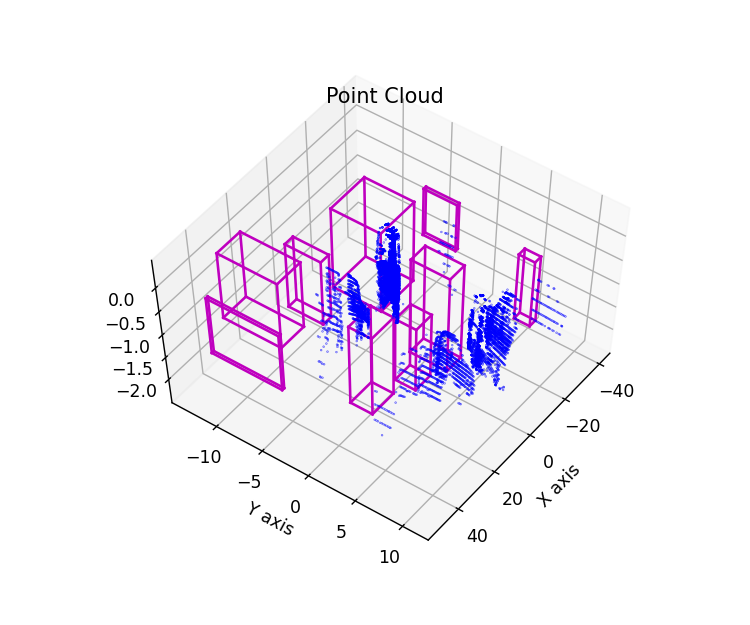

In [146]:
%matplotlib notebook
f = plt.figure(figsize=(6, 5))
axes = [0,1,2]
ax = f.add_subplot(111, projection='3d') 
# ax = f.add_subplot(111) 
draw_point_cloud(spoints.values, ax, 'Point Cloud',axes=axes)
for box in box_coord_list:
     draw_box(ax, box, axes=axes, color='m')

## Getting bounding boxes for sequence 00

In [670]:
import glob
scan_lst = glob.glob("dataset/sequences/00/velodyne/*.bin")
labels_lst = glob.glob("dataset/sequences/00/labels/*.label")
assert len(scan_lst) == len(labels_lst)
print('READ OK, number of scans ', len(scan_lst))

READ OK, number of scans  459


In [674]:
# getting num of scan
import re
def get_scan_id(scan):
    return re.findall(r'\d\d\d\d\d.', scan)[0]

print(scan_lst[0])
print(get_scan_id(scan_lst[0]))

dataset/sequences/00/velodyne/000355.bin
000355


In [672]:
%%time
# get bboxes
for scan, label in zip(sorted(scan_lst), sorted(labels_lst)):
    
    # sanity check
    scan_id = get_scan_id(scan)
    assert scan_id == get_scan_id(label)
    
    # read scan
    scan = np.fromfile(scan, dtype=np.float32)
    scan = scan.reshape((-1, 4))[:, :3]

    # read label
    label = np.fromfile(label, dtype=np.uint32)
    label = label.reshape((-1))
    
    # start pipeline 
    clusters = pipeline(scan, label, obstacle_lst)
    
    # write cluster in format x_min, x_max, y_min, y_max, z_min, z_max
    np.savetxt('dataset/sequences/00/clusters/' + str(scan_id) + '.bbox', clusters)

get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding

get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes


Empty DataFrame
Columns: [(x, a), (x, b)]
Index: []

In [86]:
# def clustering(cloud, tol, min_size, max_size):
#     """
#     Input parameters:
#         cloud: Input cloud
#         tol: tolerance
#         min_size: minimal number of points to form a cluster
#         max_size: maximal number of points that a cluster allows 
#     Output:
#         cluster_indices: a list of list. Each element list contains the indices of the points that belongs to
#                          the same cluster
#     """
#     tree = cloud.make_kdtree()
#     ec = cloud.make_EuclideanClusterExtraction()
#     ec.set_ClusterTolerance(tol)
#     ec.set_MinClusterSize(min_size)
#     ec.set_MaxClusterSize(max_size)
#     ec.set_SearchMethod(tree)
#     cluster_indices = ec.Extract()
#     return cluster_indices